# Deutsch, Deutsch-Jozsa, and Bernstein-Vazirani Algorithm

March 25, 2022 Yuri Kobayashi <br/>
For IIT Roorkee: Quantum Algorithms using Qiskit Part 1

## 1. Deutsch <a id='implementation'></a>

Let's implement Deutsch-Jozsa algorithm using Qiskit. We will start by taking a closer look at oracles.

In [ ]:
# import qiskit and necessary python libraries
import numpy as np
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#check qiskit version
import qiskit
qiskit.__qiskit_version__

<table>
<tbody>
<tr>
<td colspan="2">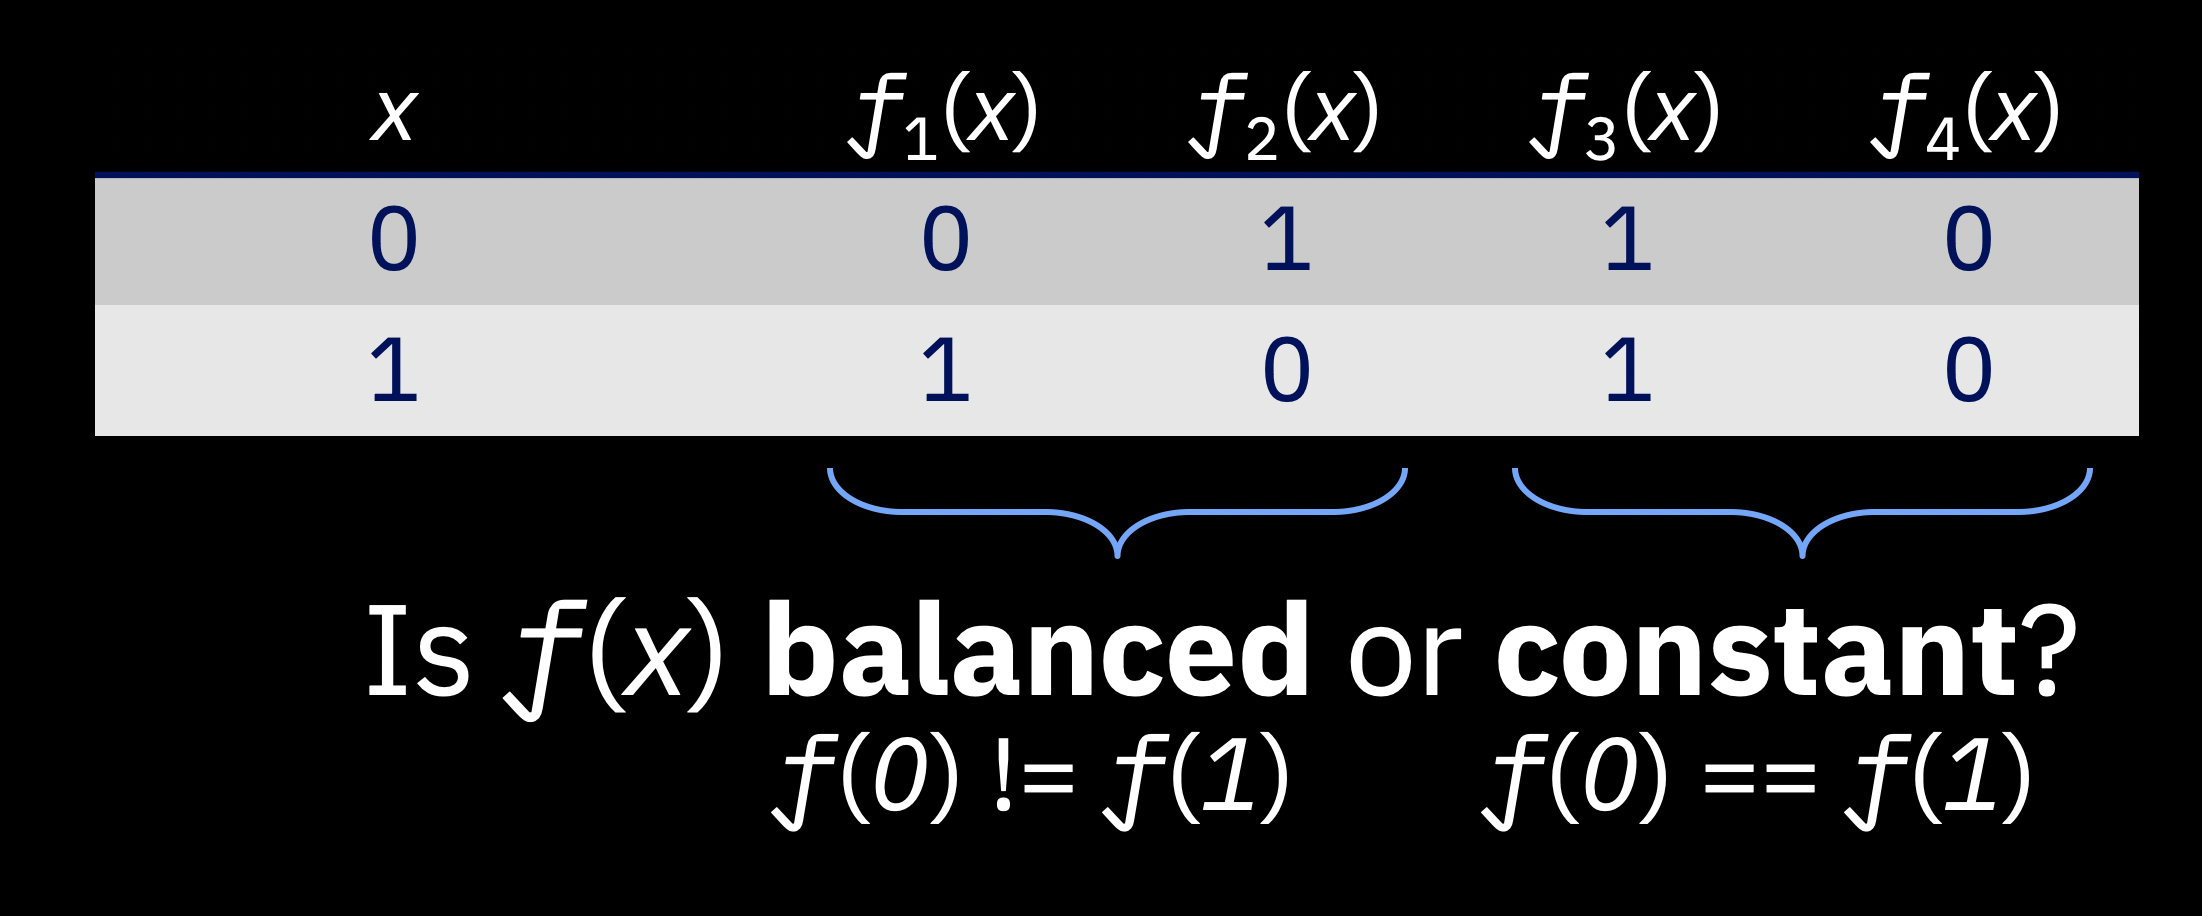</td>
</tr>
<tr>
<td>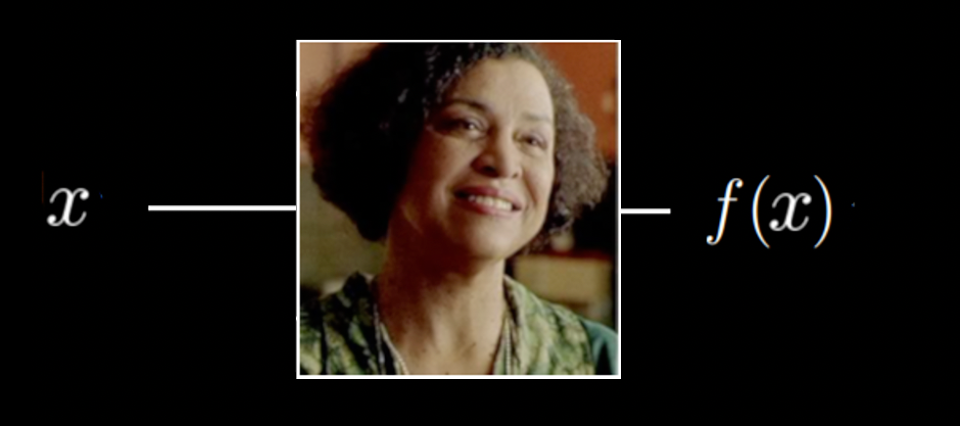</td>
<td>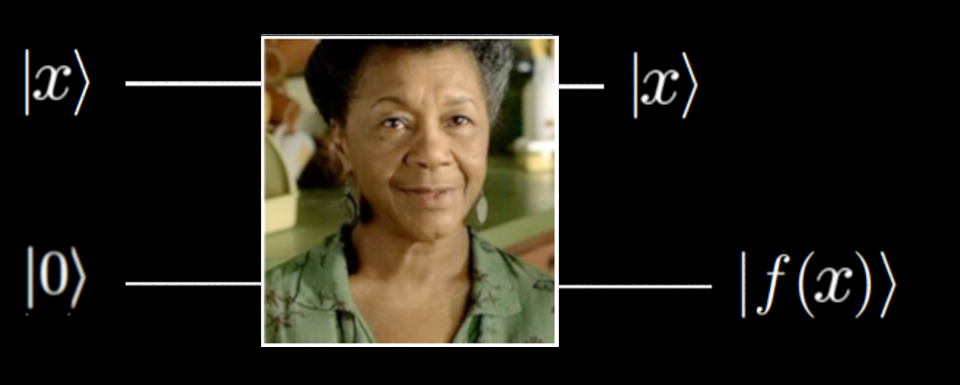</td>
</tr>
</tbody>
</table>

### Oracle 4: Constant zero

In [ ]:
control = QuantumRegister(1, name='control')
target = QuantumRegister(1, name='target')
constant0 = QuantumCircuit(control, target, name='oracle')
oracle4 = constant0.to_instruction()  #create an instruction out of a circuit
constant0.draw('mpl')

### Oracle 3: Constant one

In [ ]:
control = QuantumRegister(1, name='control')
target = QuantumRegister(1, name='target')
constant1 = QuantumCircuit(control, target, name='oracle')
constant1.x(target)
oracle3 = constant1.to_instruction()
constant1.draw('mpl')

### Oracle 1: Identity

In [ ]:
control = QuantumRegister(1, name='control')
target = QuantumRegister(1, name='target')
identity = QuantumCircuit(control, target, name='oracle')
identity.cx(control, target)
oracle1 = identity.to_instruction()
identity.draw('mpl')

### Oracle 2: Invert

In [ ]:
control = QuantumRegister(1, name='control')
target = QuantumRegister(1, name='target')
invert = QuantumCircuit(control, target, name='oracle')
invert.cx(control, target)
invert.x(target)
oracle2 = invert.to_instruction()
invert.draw('mpl')

### Run a Classic Oracle...twice

In [ ]:
result = ClassicalRegister(1, name='result')
circuit = QuantumCircuit(control, target, result)
circuit.x(control) 
circuit.barrier()
circuit.compose(oracle2, inplace=True) 
circuit.barrier()
circuit.measure(target, result)
circuit.draw('mpl')

In [ ]:
# from qiskit.tools.monitor import job_monitor
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator)
counts = job.result().get_counts()
plot_histogram(counts)

With a classic oracle, we need to run the oracle twice giving it a different input to determine whether it is balanced or not.

## Runing a Quantum Oracle  (Deutsch's Algorithm)

In [ ]:
control = QuantumRegister(1, name='control')
target = QuantumRegister(1, name='target')
result = ClassicalRegister(1, name='result')
circuit = QuantumCircuit(control, target, result)
circuit.h(control)
circuit.x(target)
circuit.h(target)
circuit.append(oracle1, [control[0], target[0]])
circuit.h(control)
circuit.measure(control[0], result[0])
circuit.draw('mpl', justify="right")

## Phase Kickback

The difference between balanced/constant is the phase factor that gets applied by a $\text{CNOT}$ in the oracle. And how to detect that phase factor in the oracle? Sice we purposely initialized the target to |-⟩ we can exploit  *phase kickback* and get it encoded to the control for us to measure the results.

In [ ]:
counts = execute(circuit, backend=simulator, shots=1).result().get_counts()
counts['BALANCED'] = counts.pop('1', None)
counts['CONSTANT'] = counts.pop('0', None)
counts

## 2 Deutsch-Jozsa <a id='full_alg'></a>

Deutsch-Jozsa is the n-qubit version of Deutsch's algorithm above. <br>
We will build the oracles just like we did in the above but expanding it to n qubits.

In [ ]:
# Let's set the length of the n-qubit input string. 
n = 3

### 2.1 Oracle 1: Constant <a id='const_function'></a>
Let's create a circuit that will give us zero no matter what the input is.

$\qquad$ 1. If f(x) = 0, apply the $I$ gate to output.(here we will do nothing)<br>
$\qquad$ 2. If f(x) = 1, apply the $X$ gate to the output.
Let's start by creating a constant function, in this case the input has no effect on the ouput so we just randomly set the output qubit to be 0 or 1:

In [ ]:
const_function = QuantumCircuit(n+1,n)

output = np.random.randint(2)  #ouput qubit is randomly set to be 0 or 1
if output == 1:
    const_function.x(n)
for i in range(n):
    const_function.measure(i, i)
const_function.draw()

In [ ]:
#check that you always get zeros no matter what the output is
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(const_function, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

### 2.2  Oracle 2: Balanced<a id='const_function'></a>

For a balanced function, just as we saw in Deutsch's example, we just need CNOTs for each conrol qubit, with the last qubit as the target. For example: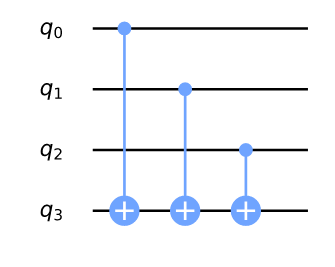

We can see which states give which output in the table below. Note that there are equal number of results that give you either an ouput 0 or a 1. Showing that it is balanced. But is this the only possible qay to create a balanced oracle?

| Outputs 0 | Outputs 1 |
|:---------:|:---------:|
|    000    |    001    |
|    011    |    100    |
|    101    |    010    |
|    110    |    111    |


We can change the results while keeping them balanced by wrapping selected controls in X-gates.
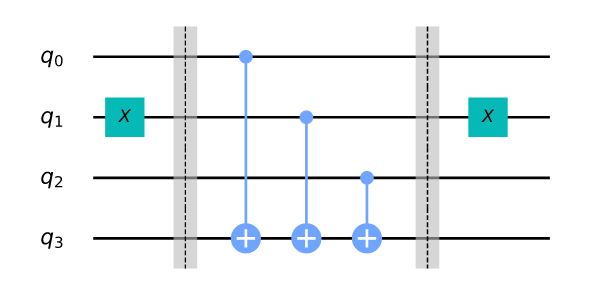

### Exercise 
Build the same circuit using Qiskit with input |𝑞2𝑞1𝑞0⟩=|010⟩ and verify the ouput on |𝑞3⟩

In [ ]:
#　Build a circuit with input |𝑞2𝑞1𝑞0⟩=|010⟩ and examine results on output register |𝑞3⟩

qc = QuantumCircuit(4)   # prepare 4 qubit circuit

qc.x(1)   # apply x gate on our control qubit 𝑞1

# apply cnots across the input and output qubits
qc.cx(0,3)
qc.cx(1,3)
qc.cx(2,3)

qc.barrier() # barrier for visual purpose

qc.x(1)  # wrap the control with x gate

qc.draw(output="mpl")    # draw circuit

Verify that we can change results by keeping them balanced. 

| Outputs 0 | Outputs 1 |
|:---------:|:---------:|
|    001    |    000    |
|    010    |    011    |
|    100    |    101    |
|    111    |    110    |

### 2.3 Balanced Function

We can create a balanced function by performing CNOTs with each input qubit as a control and the output bit as the target. We can vary the input states that give 0 or 1 by wrapping some of the controls in X-gates. Let's first choose a binary string of length `n` that dictates which controls to wrbap:

In [ ]:
balanced_function = QuantumCircuit(n+1,n)

In [ ]:
b_str = "101"

Now we have this string, we can use it as a key to place our X-gates. For each qubit in our circuit, we place an X-gate if the corresponding digit in `b_str` is `1`, or do nothing if the digit is `0`.

In [ ]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_function.x(qubit)
balanced_function.draw()

Next, we do our controlled-NOT gates, using each input qubit as a control, and the output qubit as a target:

In [ ]:
balanced_function.barrier()   #visual aid

for qubit in range(n):    #cx gates on all input qubits
    balanced_function.cx(qubit, n)

balanced_function.barrier() #visual aid
balanced_function.draw()

We finish by wrapping the controls with x-gates.

In [ ]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_function.x(qubit)
        
balanced_function.draw()

We have just created a balanced function. Now let us implement these functions into the Deutsch-Josza algorithm to solve it.

### 2.4 The Full Algorithm <a id='full_alg'></a>

To create a full algorithm, we are going to combine each step of the algorithm with the balanced function we just created. This first step in the algorithm is to initialise the input qubits in the state $|{+}\rangle$ and the output qubit in the state $|{-}\rangle$:

In [ ]:
#Let's call our circuit for the full algorithim "dj"
dj = QuantumCircuit(n+1, n)

#Step 1: Start with |0>|1>
dj.x(n) #apply x gates

#Step 2: #Step 2: Apply Hadamard on all qubits and make the auxiliary qubit |−⟩
dj.barrier()
for qubit in range(n+1):  #apply hadamard to all qubits
    dj.h(qubit)

#Step 3: Apply Uf |𝑥⟩|𝑦⟩↦|𝑥⟩|𝑓(𝑥)⊕𝑦⟩   
dj += balanced_function  #Add balanced function
# dj.draw()

#Step 4: Apply a Hadamard to the last register
dj.barrier()

for qubit in range(n):
    dj.h(qubit)

for i in range(n):
    dj.measure(i, i)

dj.draw()

### 2.5 Running our circuit on a simulator

In [ ]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We can see from the results above we measure `111` with 100% probability. This correctly predicts the function is balanced. 

### 2.6 Running our circuit on a real device
Let us try running our circuit on a real device that is least busy.

In [ ]:
# For those who are running on a real device for the first time
# from qiskit import IBMQ
# IBMQ.save_account('MY_API_TOKEN')    # insert your API token

In [ ]:
#Load IBM Q account and set provider
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# Find the least busy backend
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

In [ ]:
#Run the job on the least busy backend 
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(dj, backend=backend, shots=shots, optimization_level=3)

#Monitor job status
job_monitor(job, interval = 2)

In [ ]:
#Obtain job results and get counts
results = job.result()
answer = results.get_counts()

# Plotting answer in histogram
plot_histogram(answer)

Verify that you were able to get the answer `111` with the highest probability. The other answers you see are due to errors present in our near-term quantum systems.

### 2.7 References <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

## 3. Bernstein Vazirani Algorithm <a id='device'></a>

### 3.1 implement Bernstein Vazirani algorithm using Qiskit in  five steps. 

1. Set n + 1 qubits and the secret string s.
2. Initialize the first 𝑛 qubits in the state |0⟩, and the last qubit in the |1⟩ state. In Qiskit, all qubits are initialized in the |0⟩ state, so only need to initialize the last qubit to |1⟩ state by applying an X gate.
3. Apply Hadamard gates to all qubits.
4. Build the box containing the secret number (also known as an oracle). We will build it as a function that computes 𝑠・𝑥 modulo 2 by applying CNOT gates from the first 𝑛 qubits onto the last qubit whenever there is a 1 in the secret number. We will do this in reverse order, meaning that the there will be a CNOT gate from the 𝑛th qubit to the last qubit if the first bit of the secret number is 1. 
5. Apply a Hadamard to each qubit and Measure the first 𝑛 qubits. 

In [ ]:
#Initialize if necessary
%matplotlib inline
from qiskit import *
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

In [ ]:
# Step 1　Construct secret binary string
s = '011001'


#Create quantum circuit called 'qc' 
#Prepare n+1 qubits and n classical registers to store results. n should be tne same length as s.
n = len(s)
qc = QuantumCircuit(n+1,n)



# Step 2　Initialize the last auxiliary qubit to |1⟩

qc.x(n) #apply x gate

qc.barrier() #visual aid

# Step 3 Apply Hadamard Gates

qc.h(range(n)) #Apply hadamard gates to close circuit

qc.barrier() #visual aid


# Step 4　Build oracle that performs  𝑠・𝑥 modulo 2 by applying CNOT gates

for ii, yesno in enumerate(reversed(s)):
    if yesno == '1': 
        qc.cx(ii, n)

qc.barrier() # visual aid


# Step 5 Apply hadamard gates on input register and measure

qc.h(range(n+1)) #apply h gates

qc.barrier() #visual aid

qc.measure(range(n), range(n)) #Measure the input n qubits from 0 to n-1 and store the result in a classical register

qc.draw(output='mpl') #draw circuit

### 3.2 Running our circuit on a simulator

In [ ]:
# Run circuit on qasm simulator
simulator = Aer.get_backend('qasm_simulator')
# shots=1
result = execute(qc, backend=simulator, shots=1).result()
# plot results
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(qc))

### 3.3 Running our circuit on a real device

Let us load our account and provider first.

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='ibm-3')
IBMQ.providers() 

In [ ]:
for _backend in IBMQ.get_provider(hub='ibm-q-education', group='ibm-3').backends():
    if not (_backend.configuration().simulator):
        print(f"{_backend.name()} : {_backend.configuration().n_qubits} qubit")

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
real_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 6 
                             and not x.configuration().simulator))
print("The least busy backend is: ", real_backend)

In [ ]:
# filter = {'hubInfo.hub.name': 'ibm-q'}
# job_list = backend.jobs(limit=5, db_filter=filter)
job_list = backend.jobs()[0]
print(job_list)

In [ ]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

#plot_histogram(answer,figsize=(20,7))
plot_histogram(answer)

Verify that the results show the secret binary string. Other answers are due to error in the near-term quantum system.

### 3.4 References

1. Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473, <a id='1' href='https://doi.org/10.1137/S0097539796300921'>doi:10.1137/S0097539796300921</a>).

2. For details on the Qiskit implementation, check out the [Berstein-Vazirani Algorithm](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html) chapter in the Qiskit Textbook.

# [Qiskit Resources](https://qiskit.org/)
- [IBM Quantum Composer Introduction](https://quantum-computing.ibm.com/composer/docs/iqx/guide/)
- [IBM Quantum Lab Documentation](https://quantum-computing.ibm.com/lab/docs/iql/)


- [Qiskit Textbook](https://qiskit.org/textbook/preface.html)
- [Qiskit Tutorials](https://qiskit.org/documentation/tutorials.html)
- [Qiskit Videos](https://www.youtube.com/qiskit)
- [Qiskit Documentation](https://qiskit.org/documentation/)


- [Qiskit Twitter](https://twitter.com/Qiskit)
- [Qiskit Slack](https://ibm.co/joinqiskitslack)
- [Qiskit Blog](https://medium.com/qiskit)

Thank you and I hope you enjoy your quantum journey with Qiskit!